## Set GT outputs

For File `receipt_1.png`

In [6]:
gt_output = {'predictions': [[{'menu': [{'nm': 'FO2022081800864', 'price': '22.00'},
     {'nm': 'Lenil Soup (Vegetarian)', 'cnt': '1 x', 'price': '5.50'},
     {'nm': 'Platform Service Fee', 'price': '28.00'},
     {'nm': 'Beef Chili Soup', 'discountprice': '-25.00', 'price': '28.00'}],
    'subtotal_price': '27.62」。',
    'discount_price': '1.38.0',
    'cnt': '1 x',
    'discountprice': '-5.00',
    'price': '27.62」。'},
   {'nm': 'VAT5.00% incl.', 'num': '1.38.1.', 'price': '1.50.1.'},
   {'nm': 'Serice Fee',
    'num': 'Total',
    'price': '30.50.1.',
    'etc': 'No curey.'},
   {'nm': 'Thanks Charlie for your order. You are a rockstar/',
    'price': '293',
    'creditcardprice': '29.270.00'}]]}

gt_output_with_conf = None

gt_output_with_conf_tkn = None

## DONUT original class

In [2]:
"""
Donut
Copyright (c) 2022-present NAVER Corp.
MIT License
"""
import math
import os
import re
from typing import Any, List, Optional, Union

import numpy as np
import PIL
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import ImageOps
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.swin_transformer import SwinTransformer
from torchvision import transforms
from torchvision.transforms.functional import resize, rotate
from transformers import MBartConfig, MBartForCausalLM, XLMRobertaTokenizer
from transformers.file_utils import ModelOutput
from transformers.utils.generic import to_py_obj
from transformers.modeling_utils import PretrainedConfig, PreTrainedModel


class SwinEncoder(nn.Module):
    r"""
    Donut encoder based on SwinTransformer
    Set the initial weights and configuration with a pretrained SwinTransformer and then
    modify the detailed configurations as a Donut Encoder

    Args:
        input_size: Input image size (width, height)
        align_long_axis: Whether to rotate image if height is greater than width
        window_size: Window size(=patch size) of SwinTransformer
        encoder_layer: Number of layers of SwinTransformer encoder
        name_or_path: Name of a pretrained model name either registered in huggingface.co. or saved in local.
                      otherwise, `swin_base_patch4_window12_384` will be set (using `timm`).
    """

    def __init__(
        self,
        input_size: List[int],
        align_long_axis: bool,
        window_size: int,
        encoder_layer: List[int],
        name_or_path: Union[str, bytes, os.PathLike] = None,
    ):
        super().__init__()
        self.input_size = input_size
        self.align_long_axis = align_long_axis
        self.window_size = window_size
        self.encoder_layer = encoder_layer

        self.to_tensor = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
            ]
        )

        self.model = SwinTransformer(
            img_size=self.input_size,
            depths=self.encoder_layer,
            window_size=self.window_size,
            patch_size=4,
            embed_dim=128,
            num_heads=[4, 8, 16, 32],
            num_classes=0,
        )

        # weight init with swin
        if not name_or_path:
            swin_state_dict = timm.create_model("swin_base_patch4_window12_384", pretrained=True).state_dict()
            new_swin_state_dict = self.model.state_dict()
            for x in new_swin_state_dict:
                if x.endswith("relative_position_index") or x.endswith("attn_mask"):
                    pass
                elif (
                    x.endswith("relative_position_bias_table")
                    and self.model.layers[0].blocks[0].attn.window_size[0] != 12
                ):
                    pos_bias = swin_state_dict[x].unsqueeze(0)[0]
                    old_len = int(math.sqrt(len(pos_bias)))
                    new_len = int(2 * window_size - 1)
                    pos_bias = pos_bias.reshape(1, old_len, old_len, -1).permute(0, 3, 1, 2)
                    pos_bias = F.interpolate(pos_bias, size=(new_len, new_len), mode="bicubic", align_corners=False)
                    new_swin_state_dict[x] = pos_bias.permute(0, 2, 3, 1).reshape(1, new_len ** 2, -1).squeeze(0)
                else:
                    new_swin_state_dict[x] = swin_state_dict[x]
            self.model.load_state_dict(new_swin_state_dict)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, num_channels, height, width)
        """
        x = self.model.patch_embed(x)
        x = self.model.pos_drop(x)
        x = self.model.layers(x)
        return x

    def prepare_input(self, img: PIL.Image.Image, random_padding: bool = False) -> torch.Tensor:
        """
        Convert PIL Image to tensor according to specified input_size after following steps below:
            - resize
            - rotate (if align_long_axis is True and image is not aligned longer axis with canvas)
            - pad
        """
        img = img.convert("RGB")
        if self.align_long_axis and (
            (self.input_size[0] > self.input_size[1] and img.width > img.height)
            or (self.input_size[0] < self.input_size[1] and img.width < img.height)
        ):
            img = rotate(img, angle=-90, expand=True)
        img = resize(img, min(self.input_size))
        img.thumbnail((self.input_size[1], self.input_size[0]))
        delta_width = self.input_size[1] - img.width
        delta_height = self.input_size[0] - img.height
        if random_padding:
            pad_width = np.random.randint(low=0, high=delta_width + 1)
            pad_height = np.random.randint(low=0, high=delta_height + 1)
        else:
            pad_width = delta_width // 2
            pad_height = delta_height // 2
        padding = (
            pad_width,
            pad_height,
            delta_width - pad_width,
            delta_height - pad_height,
        )
        return self.to_tensor(ImageOps.expand(img, padding))


class BARTDecoder(nn.Module):
    """
    Donut Decoder based on Multilingual BART
    Set the initial weights and configuration with a pretrained multilingual BART model,
    and modify the detailed configurations as a Donut decoder

    Args:
        decoder_layer:
            Number of layers of BARTDecoder
        max_position_embeddings:
            The maximum sequence length to be trained
        name_or_path:
            Name of a pretrained model name either registered in huggingface.co. or saved in local,
            otherwise, `hyunwoongko/asian-bart-ecjk` will be set (using `transformers`)
    """

    def __init__(
        self, decoder_layer: int, max_position_embeddings: int, name_or_path: Union[str, bytes, os.PathLike] = None
    ):
        super().__init__()
        self.decoder_layer = decoder_layer
        self.max_position_embeddings = max_position_embeddings

        self.tokenizer = XLMRobertaTokenizer.from_pretrained(
            "hyunwoongko/asian-bart-ecjk" if not name_or_path else name_or_path
        )

        self.model = MBartForCausalLM(
            config=MBartConfig(
                is_decoder=True,
                is_encoder_decoder=False,
                add_cross_attention=True,
                decoder_layers=self.decoder_layer,
                max_position_embeddings=self.max_position_embeddings,
                vocab_size=len(self.tokenizer),
                scale_embedding=True,
                add_final_layer_norm=True,
            )
        )
        self.model.forward = self.forward  #  to get cross attentions and utilize `generate` function

        self.model.config.is_encoder_decoder = True  # to get cross-attention
        self.add_special_tokens(["<sep/>"])  # <sep/> is used for representing a list in a JSON
        self.model.model.decoder.embed_tokens.padding_idx = self.tokenizer.pad_token_id
        self.model.prepare_inputs_for_generation = self.prepare_inputs_for_inference

        # weight init with asian-bart
        if not name_or_path:
            bart_state_dict = MBartForCausalLM.from_pretrained("hyunwoongko/asian-bart-ecjk").state_dict()
            new_bart_state_dict = self.model.state_dict()
            for x in new_bart_state_dict:
                if x.endswith("embed_positions.weight") and self.max_position_embeddings != 1024:
                    new_bart_state_dict[x] = torch.nn.Parameter(
                        self.resize_bart_abs_pos_emb(
                            bart_state_dict[x],
                            self.max_position_embeddings
                            + 2,  # https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L118-L119
                        )
                    )
                elif x.endswith("embed_tokens.weight") or x.endswith("lm_head.weight"):
                    new_bart_state_dict[x] = bart_state_dict[x][: len(self.tokenizer), :]
                else:
                    new_bart_state_dict[x] = bart_state_dict[x]
            self.model.load_state_dict(new_bart_state_dict)

    def add_special_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings
        """
        newly_added_num = self.tokenizer.add_special_tokens({"additional_special_tokens": sorted(set(list_of_tokens))})
        if newly_added_num > 0:
            self.model.resize_token_embeddings(len(self.tokenizer))

    def prepare_inputs_for_inference(self, input_ids: torch.Tensor, past=None, use_cache: bool = None, **model_kwargs):
        """
        Args:
            input_ids: (batch_size, sequence_lenth)
        Returns:
            input_ids: (batch_size, sequence_length)
            attention_mask: (batch_size, sequence_length)
            encoder_hidden_states: (batch_size, sequence_length, embedding_dim)
        """
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id).long()
        if past is not None:
            input_ids = input_ids[:, -1:]
        output = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
            "encoder_hidden_states": model_kwargs["encoder_outputs"].last_hidden_state,
        }
        return output

    def forward(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        past_key_values: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        use_cache: bool = None,
        output_attentions: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[torch.Tensor] = None,
        return_dict: bool = None,
    ):
        """
        A forward fucntion to get cross attentions and utilize `generate` function

        Source:
        https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L1669-L1810

        Args:
            input_ids: (batch_size, sequence_length)
            attention_mask: (batch_size, sequence_length)
            encoder_hidden_states: (batch_size, sequence_length, hidden_size)

        Returns:
            loss: (1, )
            logits: (batch_size, sequence_length, hidden_dim)
            hidden_states: (batch_size, sequence_length, hidden_size)
            decoder_attentions: (batch_size, num_heads, sequence_length, sequence_length)
            cross_attentions: (batch_size, num_heads, sequence_length, sequence_length)
        """
        output_attentions = output_attentions if output_attentions is not None else self.model.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.model.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        outputs = self.model.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.model.lm_head(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return ModelOutput(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            decoder_attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    @staticmethod
    def resize_bart_abs_pos_emb(weight: torch.Tensor, max_length: int) -> torch.Tensor:
        """
        Resize position embeddings
        Truncate if sequence length of Bart backbone is greater than given max_length,
        else interpolate to max_length
        """
        if weight.shape[0] > max_length:
            weight = weight[:max_length, ...]
        else:
            weight = (
                F.interpolate(
                    weight.permute(1, 0).unsqueeze(0),
                    size=max_length,
                    mode="linear",
                    align_corners=False,
                )
                .squeeze(0)
                .permute(1, 0)
            )
        return weight


class DonutConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`DonutModel`]. It is used to
    instantiate a Donut model according to the specified arguments, defining the model architecture

    Args:
        input_size:
            Input image size (canvas size) of Donut.encoder, SwinTransformer in this codebase
        align_long_axis:
            Whether to rotate image if height is greater than width
        window_size:
            Window size of Donut.encoder, SwinTransformer in this codebase
        encoder_layer:
            Depth of each Donut.encoder Encoder layer, SwinTransformer in this codebase
        decoder_layer:
            Number of hidden layers in the Donut.decoder, such as BART
        max_position_embeddings
            Trained max position embeddings in the Donut decoder,
            if not specified, it will have same value with max_length
        max_length:
            Max position embeddings(=maximum sequence length) you want to train
        name_or_path:
            Name of a pretrained model name either registered in huggingface.co. or saved in local
    """

    model_type = "donut"

    def __init__(
        self,
        input_size: List[int] = [2560, 1920],
        align_long_axis: bool = False,
        window_size: int = 10,
        encoder_layer: List[int] = [2, 2, 14, 2],
        decoder_layer: int = 4,
        max_position_embeddings: int = None,
        max_length: int = 1536,
        name_or_path: Union[str, bytes, os.PathLike] = "",
        **kwargs,
    ):
        super().__init__()
        self.input_size = input_size
        self.align_long_axis = align_long_axis
        self.window_size = window_size
        self.encoder_layer = encoder_layer
        self.decoder_layer = decoder_layer
        self.max_position_embeddings = max_length if max_position_embeddings is None else max_position_embeddings
        self.max_length = max_length
        self.name_or_path = name_or_path


class DonutModel(PreTrainedModel):
    r"""
    Donut: an E2E OCR-free Document Understanding Transformer.
    The encoder maps an input document image into a set of embeddings,
    the decoder predicts a desired token sequence, that can be converted to a structured format,
    given a prompt and the encoder output embeddings
    """
    config_class = DonutConfig
    base_model_prefix = "donut"

    def __init__(self, config: DonutConfig):
        super().__init__(config)
        self.config = config
        self.encoder = SwinEncoder(
            input_size=self.config.input_size,
            align_long_axis=self.config.align_long_axis,
            window_size=self.config.window_size,
            encoder_layer=self.config.encoder_layer,
            name_or_path=self.config.name_or_path,
        )
        self.decoder = BARTDecoder(
            max_position_embeddings=self.config.max_position_embeddings,
            decoder_layer=self.config.decoder_layer,
            name_or_path=self.config.name_or_path,
        )

    def forward(self, image_tensors: torch.Tensor, decoder_input_ids: torch.Tensor, decoder_labels: torch.Tensor):
        """
        Calculate a loss given an input image and a desired token sequence,
        the model will be trained in a teacher-forcing manner

        Args:
            image_tensors: (batch_size, num_channels, height, width)
            decoder_input_ids: (batch_size, sequence_length, embedding_dim)
            decode_labels: (batch_size, sequence_length)
        """
        encoder_outputs = self.encoder(image_tensors)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_outputs,
            labels=decoder_labels,
        )
        return decoder_outputs

    def inference(
        self,
        image: PIL.Image = None,
        prompt: str = None,
        image_tensors: Optional[torch.Tensor] = None,
        prompt_tensors: Optional[torch.Tensor] = None,
        return_json: bool = True,
        return_attentions: bool = False, return_confs=True, return_tokens=True
    ):
        """
        Generate a token sequence in an auto-regressive manner,
        the generated token sequence is convereted into an ordered JSON format

        Args:
            image: input document image (PIL.Image)
            prompt: task prompt (string) to guide Donut Decoder generation
            image_tensors: (1, num_channels, height, width)
                convert prompt to tensor if image_tensor is not fed
            prompt_tensors: (1, sequence_length)
                convert image to tensor if prompt_tensor is not fed
        """
        # prepare backbone inputs (image and prompt)
        if image is None and image_tensors is None:
            raise ValueError("Expected either image or image_tensors")
        if all(v is None for v in {prompt, prompt_tensors}):
            raise ValueError("Expected either prompt or prompt_tensors")

        if image_tensors is None:
            image_tensors = self.encoder.prepare_input(image).unsqueeze(0)

        if self.device.type == "cuda":  # half is not compatible in cpu implementation.
            image_tensors = image_tensors.half()
            image_tensors = image_tensors.to(self.device)
        else:
            image_tensors = image_tensors.to(torch.bfloat16)

        if prompt_tensors is None:
            prompt_tensors = self.decoder.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

        prompt_tensors = prompt_tensors.to(self.device)

        last_hidden_state = self.encoder(image_tensors)
        if self.device.type != "cuda":
            last_hidden_state = last_hidden_state.to(torch.float32)

        encoder_outputs = ModelOutput(last_hidden_state=last_hidden_state, attentions=None)

        if len(encoder_outputs.last_hidden_state.size()) == 1:
            encoder_outputs.last_hidden_state = encoder_outputs.last_hidden_state.unsqueeze(0)
        if len(prompt_tensors.size()) == 1:
            prompt_tensors = prompt_tensors.unsqueeze(0)

        # get decoder output
        decoder_output = self.decoder.model.generate(
            decoder_input_ids=prompt_tensors,
            encoder_outputs=encoder_outputs,
            max_length=self.config.max_length,
            early_stopping=True,
            pad_token_id=self.decoder.tokenizer.pad_token_id,
            eos_token_id=self.decoder.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[self.decoder.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
            output_attentions=return_attentions,
        )

        output = {"predictions": list()}
        for seq in self.decoder.tokenizer.batch_decode(decoder_output.sequences):
            seq = seq.replace(self.decoder.tokenizer.eos_token, "").replace(self.decoder.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            
            if return_json:
                output["predictions"].append(self.token2json(seq))
            else:
                output["predictions"].append(seq)

        if return_attentions:
            output["attentions"] = {
                "self_attentions": decoder_output.decoder_attentions,
                "cross_attentions": decoder_output.cross_attentions,
            }

        return output

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.decoder.add_special_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in self.decoder.tokenizer.all_special_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def token2json(self, tokens, is_inner_value=False):
        """
        Convert a (generated) token seuqnce into an ordered JSON format
        """
        output = dict()

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            end_token = re.search(fr"</s_{key}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            if end_token is None:
                tokens = tokens.replace(start_token, "")
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE)
                if content is not None:
                    content = content.group(1).strip()
                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = self.token2json(content, is_inner_value=True)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        for leaf in content.split(r"<sep/>"):
                            leaf = leaf.strip()
                            if (
                                leaf in self.decoder.tokenizer.get_added_vocab()
                                and leaf[0] == "<"
                                and leaf[-2:] == "/>"
                            ):
                                leaf = leaf[1:-2]  # for categorical special tokens
                            output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]

                tokens = tokens[tokens.find(end_token) + len(end_token) :].strip()
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + self.token2json(tokens[6:], is_inner_value=True)

        if len(output):
            return [output] if is_inner_value else output
        else:
            return [] if is_inner_value else {"text_sequence": tokens}

    @classmethod
    def from_pretrained(
        cls,
        pretrained_model_name_or_path: Union[str, bytes, os.PathLike],
        *model_args,
        **kwargs,
    ):
        r"""
        Instantiate a pretrained donut model from a pre-trained model configuration

        Args:
            pretrained_model_name_or_path:
                Name of a pretrained model name either registered in huggingface.co. or saved in local,
                e.g., `naver-clova-ix/donut-base`, or `naver-clova-ix/donut-base-finetuned-rvlcdip`
        """
        model = super(DonutModel, cls).from_pretrained(pretrained_model_name_or_path, revision="official", *model_args, **kwargs)

        # truncate or interplolate position embeddings of donut decoder
        max_length = kwargs.get("max_length", model.config.max_position_embeddings)
        if (
            max_length != model.config.max_position_embeddings
        ):  # if max_length of trained model differs max_length you want to train
            model.decoder.model.model.decoder.embed_positions.weight = torch.nn.Parameter(
                model.decoder.resize_bart_abs_pos_emb(
                    model.decoder.model.model.decoder.embed_positions.weight,
                    max_length
                    + 2,  # https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L118-L119
                )
            )
            model.config.max_position_embeddings = max_length

        return model


In [3]:
from PIL import Image
from pprint import pprint as pp

model = DonutModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

if torch.cuda.is_available():
    model.half()
    device = torch.device("cuda")
    model.to(device)
else:
    model.encoder.to(torch.bfloat16)
model.eval()

/home/sam/donut/venv/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


DonutModel(
  (encoder): SwinEncoder(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (0): BasicLayer(
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp): M

In [4]:
img_path = "receipt_1.png"
image = Image.open(img_path).convert("RGB")

In [5]:
model.inference(image, prompt="<s_cord-v2>")

{'predictions': [[{'menu': [{'nm': 'FO2022081800864', 'price': '22.00'},
     {'nm': 'Lenil Soup (Vegetarian)', 'cnt': '1 x', 'price': '5.50'},
     {'nm': 'Platform Service Fee', 'price': '28.00'},
     {'nm': 'Beef Chili Soup', 'discountprice': '-25.00', 'price': '28.00'}],
    'subtotal_price': '27.62」。',
    'discount_price': '1.38.0',
    'cnt': '1 x',
    'discountprice': '-5.00',
    'price': '27.62」。'},
   {'nm': 'VAT5.00% incl.', 'num': '1.38.1.', 'price': '1.50.1.'},
   {'nm': 'Serice Fee',
    'num': 'Total',
    'price': '30.50.1.',
    'etc': 'No curey.'},
   {'nm': 'Thanks Charlie for your order. You are a rockstar/',
    'price': '293',
    'creditcardprice': '29.270.00'}]]}

## DONUT Internally modified flow

In [7]:
VERBOSE = True

In [8]:
img_path = "receipt_1.png"
image = Image.open(img_path).convert("RGB")

prompt: str = "<s_cord-v2>"

image_tensors = None
prompt_tensors = None
return_json = True
return_attentions = True

# prepare backbone inputs (image and prompt)
if image is None and image_tensors is None:
    raise ValueError("Expected either image or image_tensors")
if all(v is None for v in {prompt, prompt_tensors}):
    raise ValueError("Expected either prompt or prompt_tensors")

if image_tensors is None:
    image_tensors = model.encoder.prepare_input(image).unsqueeze(0)

if model.device.type == "cuda":  # half is not compatible in cpu implementation.
    image_tensors = image_tensors.half()
    image_tensors = image_tensors.to(model.device)
else:
    image_tensors = image_tensors.to(torch.bfloat16)

if prompt_tensors is None:
    prompt_tensors = model.decoder.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

prompt_tensors = prompt_tensors.to(model.device)

last_hidden_state = model.encoder(image_tensors)
if model.device.type != "cuda":
    last_hidden_state = last_hidden_state.to(torch.float32)

encoder_outputs = ModelOutput(last_hidden_state=last_hidden_state, attentions=None)

if len(encoder_outputs.last_hidden_state.size()) == 1:
    encoder_outputs.last_hidden_state = encoder_outputs.last_hidden_state.unsqueeze(0)
if len(prompt_tensors.size()) == 1:
    prompt_tensors = prompt_tensors.unsqueeze(0)

# get decoder output
decoder_output = model.decoder.model.generate(
    decoder_input_ids=prompt_tensors,
    encoder_outputs=encoder_outputs,
    max_length=model.config.max_length,
    early_stopping=True,
    pad_token_id=model.decoder.tokenizer.pad_token_id,
    eos_token_id=model.decoder.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[model.decoder.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
    output_attentions=return_attentions,
    output_scores=True,
)

output = {"predictions": list()}
decoder_confs = torch.amax(torch.stack(decoder_output.scores, dim=1).softmax(-1), 2).cpu().numpy()[0]
decoder_confs = np.concatenate([decoder_confs, [1.]], axis=0)  # add score for start token
print("len(decoder_confs) = ", len(decoder_confs), ", len(decoder_output_seqs) = ", len(decoder_output.sequences[0]))


def token2json_custom(model, tokens: str, confs: List[float], idxs: List[list], delim: str, is_inner_val: bool = False) -> List[str]:
    """
    Convert a (generated) token sequence into an ordered JSON format
    """
    output = dict()

    while tokens:
        start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
        if start_token is None:
            break
        key = start_token.group(1)
        end_token = re.search(fr"</s_{key}>", tokens, re.IGNORECASE)
        start_token = start_token.group()
        tokens_split = [tkn for tkn in tokens.split(delim) if tkn]
        assert len(tokens_split) == len(confs) == len(idxs)

        if end_token is None:
            # remove all occurences of start_token idxes from confs list and idxs list
            confs = [confs[i] for i, tkn in enumerate(tokens_split) 
                     if not re.search(start_token, tkn, re.IGNORECASE)]
            idxs = [idxs[i] for i, tkn in enumerate(tokens_split) 
                    if not re.search(start_token, tkn, re.IGNORECASE)]
            tokens = tokens.replace(start_token, "")
            tksplit = [tk for tk in tokens.split(delim) if tk]
            assert len(tksplit) == len(confs) == len(idxs)
        else:
            end_token = end_token.group()
            start_token_escaped = re.escape(start_token)
            end_token_escaped = re.escape(end_token)
            content = re.search(f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE)
            if content is not None:
                start_tkn_esc_idx = None
                end_tkn_esc_idx = None
                for i, tkn in enumerate(tokens_split):
                    # only take the first start token
                    if start_tkn_esc_idx is None and re.search(start_token_escaped, tkn, re.IGNORECASE):
                        start_tkn_esc_idx = i
                    # end_token_escaped must exist after start_token_escaped_idx exists
                    if start_tkn_esc_idx is not None and re.search(end_token_escaped, tkn, re.IGNORECASE):
                        end_tkn_esc_idx = i
                        break
                content = content.group(1).strip(delim)
                tksplit = [tk for tk in tokens.split(delim) if tk]
                content_confs = confs[start_tkn_esc_idx + 1: end_tkn_esc_idx]
                content_idxs = idxs[start_tkn_esc_idx + 1: end_tkn_esc_idx]
                cntsplit = [tk for tk in content.split(delim) if tk]

                assert len(tokens_split) == len(confs) == len(idxs)
                assert len(cntsplit) == len(content_confs) == len(content_idxs)
                
                if r"<s_" in content and r"</s_" in content:  # non-leaf node
                    value = token2json_custom(model, content, content_confs, content_idxs, delim, is_inner_val=True)
                    if VERBOSE:
                        print("value", value)
                    if value:
                        if len(value) == 1:
                            value = value[0]
                        output[key] = value
                else:  # leaf nodes
                    output[key] = []
                    if VERBOSE:
                        print("cntsplit:", cntsplit, ",   content_confs:", content_confs)
                        print("content:", content)
                        print("leaf split:", content.split(r"<sep/>"))
                    leaf_content_confs = [content_confs[i] for i, tkn in enumerate(cntsplit) 
                                         if not(re.search(r"<sep/>", tkn, re.IGNORECASE))]
                    leaf_content_idxs = [content_idxs[i] for i, tkn in enumerate(cntsplit) 
                                         if not(re.search(r"<sep/>", tkn, re.IGNORECASE))]
                    if VERBOSE:
                        print("cur_content_confs:", leaf_content_confs)
                    for leaf_i, leaf in enumerate(content.split(r"<sep/>")):
                        leaf = leaf.strip(delim)
                        if (
                            leaf in model.decoder.tokenizer.get_added_vocab()
                            and leaf[0] == "<"
                            and leaf[-2:] == "/>"
                        ):
                            leaf = leaf[1:-2]  # for categorical special tokens
                        # uncomment below to add confs
                        output[key].append([leaf, leaf_content_confs[leaf_i], leaf_content_idxs[leaf_i]])
#                         output[key].append(leaf)
                    if len(output[key]) == 1:
                        output[key] = output[key][0]
            for i, tkn in enumerate(tokens_split):
                if re.search(end_token, tkn, re.IGNORECASE):
                    confs = confs[i + 1:]
                    idxs = idxs[i + 1:]
                    break
            tokens = tokens[tokens.find(end_token) + len(end_token) :].strip(delim)
            if tokens[:6] == r"<sep/>":  # non-leaf nodes
                return [output] + token2json_custom(model, tokens[6:], confs[1:], idxs[1:], delim, is_inner_val=True)
    if len(output):
        return [output] if is_inner_val else output
    else:
        return [] if is_inner_val else {}


# model.decoder.tokenizer.batch_decode(decoder_output.sequences) function below
################################################################################################################################
decoder_output_seq  = None

token_ids = decoder_output.sequences[0]
skip_special_tokens: bool = False
clean_up_tokenization_spaces: bool = True
spaces_between_special_tokens: bool = True

# Convert inputs to python lists
token_ids = to_py_obj(token_ids)
model.decoder.tokenizer._decode_use_source_tokenizer = False
filtered_tokens = model.decoder.tokenizer.convert_ids_to_tokens(token_ids, skip_special_tokens=skip_special_tokens)

# To avoid mixing byte-level and unicode for byte-level BPT
# we need to build string separately for added tokens and byte-level tokens
# cf. https://github.com/huggingface/transformers/issues/1133
sub_texts = []
sub_confs = []
sub_idxs = []

current_sub_text = []
current_sub_confs = []
current_sub_idxs = []

assert len(filtered_tokens) == len(decoder_confs)
print("len(decoder_output.cross_attentions)", len(decoder_output.cross_attentions))
for idx, (token, conf) in enumerate(zip(filtered_tokens, decoder_confs)):
    if skip_special_tokens and token in model.decoder.tokenizer.all_special_ids:
        continue
    if token in model.decoder.tokenizer.added_tokens_encoder:
        if current_sub_text:
            sub_texts.append(model.decoder.tokenizer.convert_tokens_to_string(current_sub_text))
            current_sub_text = []
            sub_confs.append(sum(current_sub_confs) / len(current_sub_confs))
            current_sub_confs = []
            sub_idxs.append(current_sub_idxs)
            current_sub_idxs = []
        sub_texts.append(token)
        sub_confs.append(conf)
        sub_idxs.append([idx])
    else:
        current_sub_text.append(token)
        current_sub_confs.append(conf)
        current_sub_idxs.append(idx)

if current_sub_text:
    sub_texts.append(model.decoder.tokenizer.convert_tokens_to_string(current_sub_text))
    sub_confs.append(sum(current_sub_confs) / len(current_sub_confs))
    sub_idxs.append(current_sub_idxs)

DELIM = "}~}~}~{"
if spaces_between_special_tokens:
    text = DELIM.join(sub_texts)
else:
    text = "".join(sub_texts)
print("len(sub_confs) =", len(sub_confs), "len(sub_texts) =", len(sub_texts))
print(f"len(text.split({DELIM})) = ",len(re.split(f"{re.escape(DELIM)}+", text)))
print("len(sub_idxs) =", len(sub_idxs))
print()

def clean_up_tokenization(out_string: str) -> str:
    """
    Clean up a list of simple English tokenization artifacts like spaces before punctuations and abbreviated forms.
    """
    out_string = (
        out_string.replace(" .", ".")
        .replace(" ?", "?")
        .replace(" !", "!")
        .replace(" ,", ",")
        .replace(" ' ", "'")
        .replace(" n't", "n't")
        .replace(" 'm", "'m")
        .replace(" 's", "'s")
        .replace(" 've", "'ve")
        .replace(" 're", "'re")
    )
    return out_string

decoder_output_confs = sub_confs
decoder_output_indxs = sub_idxs
if clean_up_tokenization_spaces:
    clean_text = clean_up_tokenization(text)
    decoder_output_seq = clean_text
else:
    decoder_output_seq = text

# exit of function model.decoder.tokenizer.batch_decode(decoder_output.sequences)
################################################################################################################################

for seq, confs, idxs in ([[decoder_output_seq, decoder_output_confs, decoder_output_indxs]]):
    eos_tkn, pad_tkn = model.decoder.tokenizer.eos_token, model.decoder.tokenizer.pad_token

    confs = [confs[i] for i, tkn in enumerate(seq.split(DELIM)) 
             if not(re.search(eos_tkn, tkn, re.IGNORECASE) or re.search(pad_tkn, tkn, re.IGNORECASE))]
    idxs = [idxs[i] for i, tkn in enumerate(seq.split(DELIM)) 
            if not(re.search(eos_tkn, tkn, re.IGNORECASE) or re.search(pad_tkn, tkn, re.IGNORECASE))]
    seq = seq.replace(eos_tkn, "").replace(pad_tkn, "")

    for i, tkn in enumerate(seq.split(DELIM)):
        if re.search(r"<.*?>", tkn, re.IGNORECASE):  # remove first task start token conf
            confs.pop(i)
            idxs.pop(i)
            break
    seq = re.sub(r"<.*?>", "", seq, count=1).strip(DELIM)  # remove first task start token
    print("len(confs) =", len(confs), "len(idxs) =", len(idxs), f"len(text.split({DELIM})) =",len([w for w in seq.split(DELIM) if w]))
    if confs and idxs and return_json:
        output["predictions"].append(token2json_custom(model, seq, confs, idxs, delim=DELIM))
    else:
        output["predictions"].append(seq)

# if return_attentions:
#     output["attentions"] = {
#         "self_attentions": decoder_output.decoder_attentions,
#         "cross_attentions": decoder_output.cross_attentions,
#     }

len(decoder_confs) =  273 , len(decoder_output_seqs) =  273
len(decoder_output.cross_attentions) 272
len(sub_confs) = 127 len(sub_texts) = 127
len(text.split(}~}~}~{)) =  127
len(sub_idxs) = 127

len(confs) = 125 len(idxs) = 125 len(text.split(}~}~}~{)) = 125
cntsplit: ['FO2022081800864'] ,   content_confs: [0.97210693359375]
content: FO2022081800864
leaf split: ['FO2022081800864']
cur_content_confs: [0.97210693359375]
value []
cntsplit: ['22.00'] ,   content_confs: [0.999755859375]
content: 22.00
leaf split: ['22.00']
cur_content_confs: [0.999755859375]
cntsplit: ['Lenil Soup (Vegetarian)'] ,   content_confs: [0.8746202256944444]
content: Lenil Soup (Vegetarian)
leaf split: ['Lenil Soup (Vegetarian)']
cur_content_confs: [0.8746202256944444]
cntsplit: ['1 x'] ,   content_confs: [0.7578125]
content: 1 x
leaf split: ['1 x']
cur_content_confs: [0.7578125]
cntsplit: ['5.50'] ,   content_confs: [1.0]
content: 5.50
leaf split: ['5.50']
cur_content_confs: [1.0]
cntsplit: ['Platform Service Fe

In [9]:
output == gt_output, output == gt_output_with_conf, output == gt_output_with_conf_tkn

(False, False, False)

In [10]:
pp(output)

{'predictions': [[{'cnt': ['1 x', 0.95556640625, [100, 101]],
                   'discount_price': ['1.38.0',
                                      0.8272705078125,
                                      [90, 91, 92, 93]],
                   'discountprice': ['-5.00',
                                     0.70001220703125,
                                     [104, 105, 106, 107]],
                   'menu': [{'nm': ['FO2022081800864',
                                    0.97210693359375,
                                    [3, 4, 5, 6, 7, 8, 9, 10]],
                             'price': ['22.00', 0.999755859375, [22, 23]]},
                            {'cnt': ['1 x', 0.7578125, [38, 39]],
                             'nm': ['Lenil Soup (Vegetarian)',
                                    0.8746202256944444,
                                    [27, 28, 29, 30, 31, 32, 33, 34, 35]],
                             'price': ['5.50', 1.0, [42, 43]]},
                            {'nm': ['Platfor

In [11]:
[(t, i, c) for t,i,c in zip(sub_texts, sub_idxs, sub_confs)]

[('<s_cord-v2>', [0], 1.0),
 ('<s_menu>', [1], 0.98876953125),
 ('<s_nm>', [2], 0.96044921875),
 ('FO2022081800864', [3, 4, 5, 6, 7, 8, 9, 10], 0.97210693359375),
 ('</s_nm>', [11], 0.62939453125),
 ('<s_discountprice>', [12], 0.98779296875),
 ('Charlie S', [13, 14], 0.967529296875),
 ('</s_nm>', [15], 0.46435546875),
 ('<s_num>', [16], 0.58837890625),
 ('11:33:55', [17, 18, 19], 0.9694010416666666),
 ('</s_discountprice>', [20], 0.99951171875),
 ('<s_price>', [21], 0.986328125),
 ('22.00', [22, 23], 0.999755859375),
 ('</s_price>', [24], 0.9921875),
 ('<sep/>', [25], 1.0),
 ('<s_nm>', [26], 0.52099609375),
 ('Lenil Soup (Vegetarian)',
  [27, 28, 29, 30, 31, 32, 33, 34, 35],
  0.8746202256944444),
 ('</s_nm>', [36], 0.6435546875),
 ('<s_cnt>', [37], 1.0),
 ('1 x', [38, 39], 0.7578125),
 ('</s_cnt>', [40], 0.5302734375),
 ('<s_price>', [41], 0.99365234375),
 ('5.50', [42, 43], 1.0),
 ('</s_price>', [44], 0.6884765625),
 ('<sep/>', [45], 1.0),
 ('<s_nm>', [46], 0.98681640625),
 ('Platfor

## DONUT internally modified class

In [12]:
"""
Donut
Copyright (c) 2022-present NAVER Corp.
MIT License
"""
import math
import os
import re
from typing import Any, List, Optional, Tuple, Union

import cv2
import PIL
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import ImageOps
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.swin_transformer import SwinTransformer
from torchvision import transforms
from torchvision.transforms.functional import resize, rotate
from transformers import MBartConfig, MBartForCausalLM, XLMRobertaTokenizer
from transformers.file_utils import ModelOutput
from transformers.utils.generic import to_py_obj
from transformers.modeling_utils import PretrainedConfig, PreTrainedModel


class SwinEncoder(nn.Module):
    r"""
    Donut encoder based on SwinTransformer
    Set the initial weights and configuration with a pretrained SwinTransformer and then
    modify the detailed configurations as a Donut Encoder

    Args:
        input_size: Input image size (width, height)
        align_long_axis: Whether to rotate image if height is greater than width
        window_size: Window size(=patch size) of SwinTransformer
        encoder_layer: Number of layers of SwinTransformer encoder
        name_or_path: Name of a pretrained model name either registered in huggingface.co. or saved in local.
                      otherwise, `swin_base_patch4_window12_384` will be set (using `timm`).
    """

    def __init__(
        self,
        input_size: List[int],
        align_long_axis: bool,
        window_size: int,
        encoder_layer: List[int],
        name_or_path: Union[str, bytes, os.PathLike] = None,
    ):
        super().__init__()
        self.input_size = input_size
        self.align_long_axis = align_long_axis
        self.window_size = window_size
        self.encoder_layer = encoder_layer

        self.to_tensor = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
            ]
        )

        self.model = SwinTransformer(
            img_size=self.input_size,
            depths=self.encoder_layer,
            window_size=self.window_size,
            patch_size=4,
            embed_dim=128,
            num_heads=[4, 8, 16, 32],
            num_classes=0,
        )

        # weight init with swin
        if not name_or_path:
            swin_state_dict = timm.create_model("swin_base_patch4_window12_384", pretrained=True).state_dict()
            new_swin_state_dict = self.model.state_dict()
            for x in new_swin_state_dict:
                if x.endswith("relative_position_index") or x.endswith("attn_mask"):
                    pass
                elif (
                    x.endswith("relative_position_bias_table")
                    and self.model.layers[0].blocks[0].attn.window_size[0] != 12
                ):
                    pos_bias = swin_state_dict[x].unsqueeze(0)[0]
                    old_len = int(math.sqrt(len(pos_bias)))
                    new_len = int(2 * window_size - 1)
                    pos_bias = pos_bias.reshape(1, old_len, old_len, -1).permute(0, 3, 1, 2)
                    pos_bias = F.interpolate(pos_bias, size=(new_len, new_len), mode="bicubic", align_corners=False)
                    new_swin_state_dict[x] = pos_bias.permute(0, 2, 3, 1).reshape(1, new_len ** 2, -1).squeeze(0)
                else:
                    new_swin_state_dict[x] = swin_state_dict[x]
            self.model.load_state_dict(new_swin_state_dict)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (batch_size, num_channels, height, width)
        """
        x = self.model.patch_embed(x)
        x = self.model.pos_drop(x)
        x = self.model.layers(x)
        return x

    def prepare_input(self, img: PIL.Image.Image, random_padding: bool = False) -> torch.Tensor:
        """
        Convert PIL Image to tensor according to specified input_size after following steps below:
            - resize
            - rotate (if align_long_axis is True and image is not aligned longer axis with canvas)
            - pad
        """
        img = img.convert("RGB")
        if self.align_long_axis and (
            (self.input_size[0] > self.input_size[1] and img.width > img.height)
            or (self.input_size[0] < self.input_size[1] and img.width < img.height)
        ):
            img = rotate(img, angle=-90, expand=True)
        img = resize(img, min(self.input_size))
        img.thumbnail((self.input_size[1], self.input_size[0]))
        delta_width = self.input_size[1] - img.width
        delta_height = self.input_size[0] - img.height
        if random_padding:
            pad_width = np.random.randint(low=0, high=delta_width + 1)
            pad_height = np.random.randint(low=0, high=delta_height + 1)
        else:
            pad_width = delta_width // 2
            pad_height = delta_height // 2
        padding = (
            pad_width,
            pad_height,
            delta_width - pad_width,
            delta_height - pad_height,
        )
        return self.to_tensor(ImageOps.expand(img, padding))


class BARTCustomTokenizer(XLMRobertaTokenizer):
    """
    Customized XLMRobertaTokenizer to return confidence scores and token id groups aligned with grouped tokens
    The default batch_decoder, decode and _decode are overwritten for the Tokenizer
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def batch_decode(
        self,
        sequences: Union[List[int], List[List[int]], "np.ndarray", "torch.Tensor"],
        confidences: Union[List[float], List[List[float]], "np.ndarray"],
        decoder_delim: str,
        skip_special_tokens: bool = False,
        clean_up_tokenization_spaces: bool = True,
        **kwargs
    ) -> List[str]:
        """
        Convert a list of lists of token ids into a list of strings by calling decode.
        Args:
            sequences (`Union[List[int], List[List[int]], np.ndarray, torch.Tensor, tf.Tensor]`):
                List of tokenized input ids. Can be obtained using the `__call__` method.
            confidences (`Union[List[float], List[List[float]], np.ndarray]`):
                List of confidence scores for corresponding tokens in sequences list
            decoder_delim ('str'):
                delimiter for the decoded tokens, must q unique token that should not appear in text
            skip_special_tokens (`bool`, *optional*, defaults to `False`):
                Whether or not to remove special tokens in the decoding.
            clean_up_tokenization_spaces (`bool`, *optional*, defaults to `True`):
                Whether or not to clean up the tokenization spaces.
            kwargs (additional keyword arguments, *optional*):
                Will be passed to the underlying model specific decode method.
        Returns:
            `List[str]`: The list of decoded sentences.
        """
        self.DELIM = decoder_delim
        return [
            self.decode(
                seq,
                conf,
                skip_special_tokens=skip_special_tokens,
                clean_up_tokenization_spaces=clean_up_tokenization_spaces,
                **kwargs,
            )
            for seq, conf in zip(sequences, confidences)
        ]

    def decode(
        self,
        token_ids: Union[int, List[int], "np.ndarray", "torch.Tensor"],
        token_confs: Union[int, List[float], "np.ndarray"],
        skip_special_tokens: bool = False,
        clean_up_tokenization_spaces: bool = True,
        **kwargs
    ) -> str:
        """
        Converts a sequence of ids in a string, using the tokenizer and vocabulary with options to remove special
        tokens and clean up tokenization spaces.
        Similar to doing `self.convert_tokens_to_string(self.convert_ids_to_tokens(token_ids))`.
        Args:
            token_ids (`Union[int, List[int], np.ndarray, torch.Tensor, tf.Tensor]`):
                List of tokenized input ids. Can be obtained using the `__call__` method.
            token_confs (`Union[float, List[float], np.ndarray]`):
                List of confidence scores for corresponding tokens
            skip_special_tokens (`bool`, *optional*, defaults to `False`):
                Whether or not to remove special tokens in the decoding.
            clean_up_tokenization_spaces (`bool`, *optional*, defaults to `True`):
                Whether or not to clean up the tokenization spaces.
            kwargs (additional keyword arguments, *optional*):
                Will be passed to the underlying model specific decode method.
        Returns:
            `str`: The decoded sentence.
        """
        # Convert inputs to python lists
        token_ids = to_py_obj(token_ids)
        token_confs = to_py_obj(token_confs)

        return self._decode(
            token_ids=token_ids,
            token_confs=token_confs,
            skip_special_tokens=skip_special_tokens,
            clean_up_tokenization_spaces=clean_up_tokenization_spaces,
            **kwargs,
        )

    def _decode(
        self,
        token_ids: List[int],
        token_confs: List[float],
        skip_special_tokens: bool = False,
        clean_up_tokenization_spaces: bool = True,
        spaces_between_special_tokens: bool = True,
        **kwargs
    ) -> str:
        self._decode_use_source_tokenizer = kwargs.pop("use_source_tokenizer", False)

        filtered_tokens = self.convert_ids_to_tokens(token_ids, skip_special_tokens=skip_special_tokens)

        # To avoid mixing byte-level and unicode for byte-level BPT
        # we need to build string separately for added tokens and byte-level tokens
        # cf. https://github.com/huggingface/transformers/issues/1133
        sub_texts = []
        sub_confs = []
        sub_idxs = []
        current_sub_text = []
        current_sub_confs = []
        current_sub_idxs = []

        for idx, (token, conf) in enumerate(zip(filtered_tokens, token_confs)):
            if skip_special_tokens and token in self.all_special_ids:
                continue
            if token in self.added_tokens_encoder:
                if current_sub_text:
                    sub_texts.append(self.convert_tokens_to_string(current_sub_text))
                    current_sub_text = []
                    sub_confs.append(sum(current_sub_confs) / len(current_sub_confs))
                    current_sub_confs = []
                    sub_idxs.append(current_sub_idxs)
                    current_sub_idxs = []
                sub_texts.append(token)
                sub_confs.append(conf)
                sub_idxs.append([idx])
            else:
                current_sub_text.append(token)
                current_sub_confs.append(conf)
                current_sub_idxs.append(idx)

        if current_sub_text:
            sub_texts.append(self.convert_tokens_to_string(current_sub_text))
            sub_confs.append(sum(current_sub_confs) / len(current_sub_confs))
            sub_idxs.append(current_sub_idxs)

        decoder_output_confs = sub_confs
        decoder_output_indxs = sub_idxs
        if spaces_between_special_tokens:
            text = self.DELIM.join(sub_texts)
        else:
            text = "".join(sub_texts)

        if clean_up_tokenization_spaces:
            clean_text = self.clean_up_tokenization(text)
            return clean_text, decoder_output_confs, decoder_output_indxs
        else:
            return text, decoder_output_confs, decoder_output_indxs


class BARTDecoder(nn.Module):
    """
    Donut Decoder based on Multilingual BART
    Set the initial weights and configuration with a pretrained multilingual BART model,
    and modify the detailed configurations as a Donut decoder

    Args:
        decoder_layer:
            Number of layers of BARTDecoder
        max_position_embeddings:
            The maximum sequence length to be trained
        name_or_path:
            Name of a pretrained model name either registered in huggingface.co. or saved in local,
            otherwise, `hyunwoongko/asian-bart-ecjk` will be set (using `transformers`)
    """

    def __init__(
        self, decoder_layer: int, max_position_embeddings: int, name_or_path: Union[str, bytes, os.PathLike] = None
    ):
        super().__init__()
        self.decoder_layer = decoder_layer
        self.max_position_embeddings = max_position_embeddings

        self.tokenizer = BARTCustomTokenizer.from_pretrained(
            "hyunwoongko/asian-bart-ecjk" if not name_or_path else name_or_path
        )

        self.model = MBartForCausalLM(
            config=MBartConfig(
                is_decoder=True,
                is_encoder_decoder=False,
                add_cross_attention=True,
                decoder_layers=self.decoder_layer,
                max_position_embeddings=self.max_position_embeddings,
                vocab_size=len(self.tokenizer),
                scale_embedding=True,
                add_final_layer_norm=True,
            )
        )
        self.model.forward = self.forward  # to get cross attentions and utilize `generate` function

        self.model.config.is_encoder_decoder = True  # to get cross-attention
        self.add_special_tokens(["<sep/>"])  # <sep/> is used for representing a list in a JSON
        self.model.model.decoder.embed_tokens.padding_idx = self.tokenizer.pad_token_id
        self.model.prepare_inputs_for_generation = self.prepare_inputs_for_inference

        # weight init with asian-bart
        if not name_or_path:
            bart_state_dict = MBartForCausalLM.from_pretrained("hyunwoongko/asian-bart-ecjk").state_dict()
            new_bart_state_dict = self.model.state_dict()
            for x in new_bart_state_dict:
                if x.endswith("embed_positions.weight") and self.max_position_embeddings != 1024:
                    new_bart_state_dict[x] = torch.nn.Parameter(
                        self.resize_bart_abs_pos_emb(
                            bart_state_dict[x],
                            self.max_position_embeddings
                            + 2,  # https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L118-L119
                        )
                    )
                elif x.endswith("embed_tokens.weight") or x.endswith("lm_head.weight"):
                    new_bart_state_dict[x] = bart_state_dict[x][: len(self.tokenizer), :]
                else:
                    new_bart_state_dict[x] = bart_state_dict[x]
            self.model.load_state_dict(new_bart_state_dict)

    def add_special_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings
        """
        newly_added_num = self.tokenizer.add_special_tokens({"additional_special_tokens": sorted(set(list_of_tokens))})
        if newly_added_num > 0:
            self.model.resize_token_embeddings(len(self.tokenizer))

    def prepare_inputs_for_inference(self, input_ids: torch.Tensor, past=None, use_cache: bool = None, **model_kwargs):
        """
        Args:
            input_ids: (batch_size, sequence_lenth)
        Returns:
            input_ids: (batch_size, sequence_length)
            attention_mask: (batch_size, sequence_length)
            encoder_hidden_states: (batch_size, sequence_length, embedding_dim)
        """
        attention_mask = input_ids.ne(self.tokenizer.pad_token_id).long()
        if past is not None:
            input_ids = input_ids[:, -1:]
        output = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "past_key_values": past,
            "use_cache": use_cache,
            "encoder_hidden_states": model_kwargs["encoder_outputs"].last_hidden_state,
        }
        return output

    def forward(
        self,
        input_ids,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        past_key_values: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        use_cache: bool = None,
        output_attentions: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[torch.Tensor] = None,
        return_dict: bool = None,
    ):
        """
        A forward fucntion to get cross attentions and utilize `generate` function

        Source:
        https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L1669-L1810

        Args:
            input_ids: (batch_size, sequence_length)
            attention_mask: (batch_size, sequence_length)
            encoder_hidden_states: (batch_size, sequence_length, hidden_size)

        Returns:
            loss: (1, )
            logits: (batch_size, sequence_length, hidden_dim)
            hidden_states: (batch_size, sequence_length, hidden_size)
            decoder_attentions: (batch_size, num_heads, sequence_length, sequence_length)
            cross_attentions: (batch_size, num_heads, sequence_length, sequence_length)
        """
        output_attentions = output_attentions if output_attentions is not None else self.model.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.model.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        outputs = self.model.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.model.lm_head(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return ModelOutput(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            decoder_attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    @staticmethod
    def resize_bart_abs_pos_emb(weight: torch.Tensor, max_length: int) -> torch.Tensor:
        """
        Resize position embeddings
        Truncate if sequence length of Bart backbone is greater than given max_length,
        else interpolate to max_length
        """
        if weight.shape[0] > max_length:
            weight = weight[:max_length, ...]
        else:
            weight = (
                F.interpolate(
                    weight.permute(1, 0).unsqueeze(0),
                    size=max_length,
                    mode="linear",
                    align_corners=False,
                )
                .squeeze(0)
                .permute(1, 0)
            )
        return weight


class DonutConfig(PretrainedConfig):
    r"""
    This is the configuration class to store the configuration of a [`DonutModel`]. It is used to
    instantiate a Donut model according to the specified arguments, defining the model architecture

    Args:
        input_size:
            Input image size (canvas size) of Donut.encoder, SwinTransformer in this codebase
        align_long_axis:
            Whether to rotate image if height is greater than width
        window_size:
            Window size of Donut.encoder, SwinTransformer in this codebase
        encoder_layer:
            Depth of each Donut.encoder Encoder layer, SwinTransformer in this codebase
        decoder_layer:
            Number of hidden layers in the Donut.decoder, such as BART
        max_position_embeddings
            Trained max position embeddings in the Donut decoder,
            if not specified, it will have same value with max_length
        max_length:
            Max position embeddings(=maximum sequence length) you want to train
        name_or_path:
            Name of a pretrained model name either registered in huggingface.co. or saved in local
    """

    model_type = "donut"

    def __init__(
        self,
        input_size: List[int] = [2560, 1920],
        align_long_axis: bool = False,
        window_size: int = 10,
        encoder_layer: List[int] = [2, 2, 14, 2],
        decoder_layer: int = 4,
        max_position_embeddings: int = None,
        max_length: int = 1536,
        name_or_path: Union[str, bytes, os.PathLike] = "",
        **kwargs,
    ):
        super().__init__()
        self.input_size = input_size
        self.align_long_axis = align_long_axis
        self.window_size = window_size
        self.encoder_layer = encoder_layer
        self.decoder_layer = decoder_layer
        self.max_position_embeddings = max_length if max_position_embeddings is None else max_position_embeddings
        self.max_length = max_length
        self.name_or_path = name_or_path


class DonutModel(PreTrainedModel):
    r"""
    Donut: an E2E OCR-free Document Understanding Transformer.
    The encoder maps an input document image into a set of embeddings,
    the decoder predicts a desired token sequence, that can be converted to a structured format,
    given a prompt and the encoder output embeddings
    """
    config_class = DonutConfig
    base_model_prefix = "donut"

    def __init__(self, config: DonutConfig):
        super().__init__(config)
        self.config = config
        self.encoder = SwinEncoder(
            input_size=self.config.input_size,
            align_long_axis=self.config.align_long_axis,
            window_size=self.config.window_size,
            encoder_layer=self.config.encoder_layer,
            name_or_path=self.config.name_or_path,
        )
        self.decoder = BARTDecoder(
            max_position_embeddings=self.config.max_position_embeddings,
            decoder_layer=self.config.decoder_layer,
            name_or_path=self.config.name_or_path,
        )

    def forward(self, image_tensors: torch.Tensor, decoder_input_ids: torch.Tensor, decoder_labels: torch.Tensor):
        """
        Calculate a loss given an input image and a desired token sequence,
        the model will be trained in a teacher-forcing manner

        Args:
            image_tensors: (batch_size, num_channels, height, width)
            decoder_input_ids: (batch_size, sequence_length, embedding_dim)
            decode_labels: (batch_size, sequence_length)
        """
        encoder_outputs = self.encoder(image_tensors)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            encoder_hidden_states=encoder_outputs,
            labels=decoder_labels,
        )
        return decoder_outputs

    @staticmethod
    def apply_fusion(
        fusion_mode: str, 
        unfused_tensor: 
        torch.Tensor, dim: int
    ) -> torch.Tensor:
        # for donut
        # decoder num attention-head = 16, decoder num layers = 4
        # len(decoder_output.cross_attentions[0]) = 4
        # decoder_output.cross_attentions[0][0].shape = torch.Size([1, 16, 1, 1200])
        if fusion_mode == "mean":
            fused_tensor = torch.mean(unfused_tensor, dim=dim)
        elif fusion_mode == "max":
            fused_tensor = torch.max(unfused_tensor, dim=dim)[0]
        elif fusion_mode == "min":
            fused_tensor = torch.min(unfused_tensor, dim=dim)[0]
        else:
            raise NotImplementedError(f"{fusion_mode} fusion not supported")
        return fused_tensor
    
    @staticmethod
    def max_bbox_from_heatmap(
        decoder_cross_attentions: torch.Tensor, 
        tkn_indexes: List[int], 
        final_h: int = 1280, 
        final_w: int = 960,
        heatmap_h: int = 40,
        heatmap_w: int = 30,
        return_thres_agg_heatmap: bool = False
    ) -> Union[Tuple[int, int, int, int], Tuple[Tuple[int, int, int, int], np.ndarray]]:
        """
        decoder_cross_attention: tuple(tuple(torch.FloatTensor))
        Tuple (one element for each generated token) of tuples (one element for each layer of the decoder) of
         `torch.FloatTensor` of shape `(batch_size, num_heads, generated_length, sequence_length)`
        """
        agg_heatmap = np.zeros([final_h, final_w], dtype=np.uint8)
        head_fusion_type = ["mean", "max", "min"][1]
        layer_fusion_type = ["mean", "max", "min"][1]

        for tidx in tkn_indexes:    
            hmaps = torch.stack(decoder_cross_attentions[tidx], dim=0)
            # shape [4, 1, 16, 1, 1200]->[4, 16, 1200]
            hmaps = hmaps.permute(1, 3, 0, 2, 4).squeeze(0)
            hmaps = hmaps[-1]
            # change shape [4, 16, 1200]->[4, 16, 40, 30] assuming (heatmap_h, heatmap_w) = (40, 30)
            hmaps = hmaps.view(4, 16, heatmap_h, heatmap_w)
            # fusing 16 decoder attention heads i.e. [4, 16, 40, 30]-> [16, 40, 30]
            hmaps = DonutModel.apply_fusion(head_fusion_type, hmaps, dim=1)
            # fusing 4 decoder layers from BART i.e. [16, 40, 30]-> [40, 30]
            hmap = DonutModel.apply_fusion(layer_fusion_type, hmaps, dim=0)
            
            # dropping discard ratio activations
            flat = hmap.view(heatmap_h * heatmap_w)
            discard_ratio = 0.999
            _, indices = flat.topk(int(flat.size(-1) * discard_ratio), largest=False)
            flat[indices] = 0
            hmap = flat.view(heatmap_h, heatmap_w)

            hmap = hmap.unsqueeze(dim=-1).cpu().numpy()
            hmap = (hmap * 255.).astype(np.uint8)  # (40, 30, 1) uint8
            # fuse heatmaps for different tokens by taking the max
            agg_heatmap = np.max(np.asarray([agg_heatmap, cv2.resize(hmap, (final_w, final_h))]), axis=0).astype(np.uint8)

        # threshold to remove small attention pockets
        thres_heatmap = cv2.threshold(agg_heatmap, 200, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        # Find contours
        contours = cv2.findContours(thres_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        bboxes = [cv2.boundingRect(ctr) for ctr in contours]
        # return box with max area
        x, y, w, h = max(bboxes, key=lambda box: box[2] * box[3])
        max_area_box = [x, y, x + w, y + h]
        if return_thres_agg_heatmap:
            return max_area_box, thres_heatmap, agg_heatmap
        return max_area_box

    def inference(
        self,
        image: PIL.Image = None,
        prompt: str = None,
        image_tensors: Optional[torch.Tensor] = None,
        prompt_tensors: Optional[torch.Tensor] = None,
        return_json: bool = True,
        return_confs: bool = True,
        return_tokens: bool = False,
        return_attentions: bool = False,
        return_max_bbox: bool = False,
        nested_list_set: set = {"Items", "items"},
        nested_dict_set: set = {"terms", "total", "shipto", "customer", "vendor", "invoice"}
    ):
        """
        Generate a token sequence in an auto-regressive manner,
        the generated token sequence is convereted into an ordered JSON format

        Args:
            image: input document image (PIL.Image)
            prompt: task prompt (string) to guide Donut Decoder generation
            image_tensors: (1, num_channels, height, width)
                convert prompt to tensor if image_tensor is not fed
            prompt_tensors: (1, sequence_length)
                convert image to tensor if prompt_tensor is not fed
            nested_list_set: Fields that are nested lists of dicts
            nested_dict_set: Fields that are nested dicts
        """
        # prepare backbone inputs (image and prompt)
        if image is None and image_tensors is None:
            raise ValueError("Expected either image or image_tensors")
        if all(v is None for v in {prompt, prompt_tensors}):
            raise ValueError("Expected either prompt or prompt_tensors")

        if image_tensors is None:
            image_tensors = self.encoder.prepare_input(image).unsqueeze(0)

        if self.device.type == "cuda":  # half is not compatible in cpu implementation.
            image_tensors = image_tensors.half()
            image_tensors = image_tensors.to(self.device)
        else:
            image_tensors = image_tensors.to(torch.bfloat16)

        if prompt_tensors is None:
            prompt_tensors = self.decoder.tokenizer(prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

        prompt_tensors = prompt_tensors.to(self.device)

        last_hidden_state = self.encoder(image_tensors)
        if self.device.type != "cuda":
            last_hidden_state = last_hidden_state.to(torch.float32)

        encoder_outputs = ModelOutput(last_hidden_state=last_hidden_state, attentions=None)

        if len(encoder_outputs.last_hidden_state.size()) == 1:
            encoder_outputs.last_hidden_state = encoder_outputs.last_hidden_state.unsqueeze(0)
        if len(prompt_tensors.size()) == 1:
            prompt_tensors = prompt_tensors.unsqueeze(0)

        # get decoder output
        decoder_output = self.decoder.model.generate(
            decoder_input_ids=prompt_tensors,
            encoder_outputs=encoder_outputs,
            max_length=self.config.max_length,
            early_stopping=True,
            pad_token_id=self.decoder.tokenizer.pad_token_id,
            eos_token_id=self.decoder.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[self.decoder.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
            output_attentions=True,
            output_scores=True,
        )

        decoder_output_confs = torch.amax(torch.stack(decoder_output.scores, dim=1).softmax(-1), 2).cpu().numpy()[0]
        # add score for end token and wrap scores in a list
        decoder_output_confs = [np.concatenate([decoder_output_confs, [1.]], axis=0)]

        output = {"predictions": list()}
        self.return_tokens = return_tokens
        self.return_confs = return_confs
        self.DELIM = "}~}~}~{"  # important, use a DELIM that has a very low prob of appearing in text

        for idx, (seq, confs, idxs) in enumerate(self.decoder.tokenizer.batch_decode(decoder_output.sequences, decoder_output_confs, self.DELIM)):
            eos_tkn, pad_tkn = self.decoder.tokenizer.eos_token, self.decoder.tokenizer.pad_token
            split_seq = [tkn for tkn in seq.split(self.DELIM) if tkn]
            confs = [confs[i] for i, tkn in enumerate(split_seq)
                     if not(tkn.strip().lower() == eos_tkn.lower() or tkn.strip().lower() == pad_tkn.lower())]
            idxs = [idxs[i] for i, tkn in enumerate(seq.split(self.DELIM))
                    if not(tkn.strip().lower() == eos_tkn.lower() or tkn.strip().lower() == pad_tkn.lower())]
            seq = seq.replace(eos_tkn, "").replace(pad_tkn, "")
            for i, tkn in enumerate(seq.split(self.DELIM)):
                if re.search(r"<.*?>", tkn, re.IGNORECASE):  # remove first task start token conf
                    confs.pop(i)
                    idxs.pop(i)
                    break
            seq = re.sub(r"<.*?>", "", seq, count=1).strip(self.DELIM)  # remove first task start token
            if confs and idxs and return_json:
                if return_confs or return_tokens:
                    output["predictions"].append(self.token2json_with_confs(seq, confs, idxs, delim=self.DELIM))
                else:
                    seq = seq.replace(self.DELIM, ' ')
                    output["predictions"].append(self.token2json(seq))
            else:
                output["predictions"].append(seq)

        if return_attentions:
            output["attentions"] = {
                "self_attentions": decoder_output.decoder_attentions,
                "cross_attentions": decoder_output.cross_attentions,
            }
        if return_max_bbox and return_confs and return_tokens:
            preds_with_max_bbox = []
            for pred_obj in output["predictions"]:
                temp_pred_obj = {}
                for top_key, top_val in pred_obj.items():
                    if top_key in nested_list_set:
                        top_val = [top_val] if not isinstance(top_val, list) else top_val
                        temp_pred_obj[top_key] = []
                        for item in top_val:
                            temp_item_obj = {}
                            for item_key, item_val in item.items():
                                text, conf, tokens = item_val
                                max_bbox = DonutModel.max_bbox_from_heatmap(
                                    decoder_cross_attentions=decoder_output.cross_attentions,
                                    tkn_indexes=tokens, final_h=1280, final_w=960
                                )
                                temp_item_obj[item_key] = [text, conf, tokens, max_bbox]
                            temp_pred_obj[top_key].append(temp_item_obj)
                    elif top_key in nested_dict_set:
                        temp_item_obj = {}
                        for sub_key, sub_val in top_val.items():
                            text, conf, tokens = sub_val
                            max_bbox = DonutModel.max_bbox_from_heatmap(
                                decoder_cross_attentions=decoder_output.cross_attentions,
                                tkn_indexes=tokens, final_h=1280, final_w=960
                            )
                            temp_item_obj[sub_key] = [text, conf, tokens, max_bbox]
                        temp_pred_obj[top_key] = temp_item_obj
                    else:
                        text, conf, tokens = top_val
                        max_bbox = DonutModel.max_bbox_from_heatmap(
                            decoder_cross_attentions=decoder_output.cross_attentions,
                            tkn_indexes=tokens, final_h=1280, final_w=960
                        )
                        temp_pred_obj[top_key] = [text, conf, tokens, max_bbox]
                preds_with_max_bbox.append(temp_pred_obj)
    
            output["predictions"] = preds_with_max_bbox

        return output

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.decoder.add_special_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in self.decoder.tokenizer.all_special_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def token2json(self, tokens: str, is_inner_value: bool = False) -> List[dict]:
        """
        Convert a (generated) token seuqnce into an ordered JSON format
        """
        output = dict()

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            end_token = re.search(fr"</s_{key}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            if end_token is None:
                tokens = tokens.replace(start_token, "")
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE)
                if content is not None:
                    content = content.group(1).strip()
                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = self.token2json(content, is_inner_value=True)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        for leaf in content.split(r"<sep/>"):
                            leaf = leaf.strip()
                            if (
                                leaf in self.decoder.tokenizer.get_added_vocab()
                                and leaf[0] == "<"
                                and leaf[-2:] == "/>"
                            ):
                                leaf = leaf[1:-2]  # for categorical special tokens
                            output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]

                tokens = tokens[tokens.find(end_token) + len(end_token):].strip()
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + self.token2json(tokens[6:], is_inner_value=True)

        if len(output):
            return [output] if is_inner_value else output
        else:
            return [] if is_inner_value else {"text_sequence": tokens}

    def token2json_with_confs(self, tokens: str, confs: List[float], idxs: List[list], delim: str, is_inner_val: bool = False) -> List[str]:
        """
        Convert a (generated) token sequence into an ordered JSON format
        """
        output = dict()

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            end_token = re.search(fr"</s_{key}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            tokens_split = [tkn for tkn in tokens.split(delim) if tkn]
            assert len(tokens_split) == len(confs) == len(idxs)

            if end_token is None:
                # remove all occurences of start_token idxes from confs list and idxs list
                confs = [confs[i] for i, tkn in enumerate(tokens_split)
                         if not re.search(start_token, tkn, re.IGNORECASE)]
                idxs = [idxs[i] for i, tkn in enumerate(tokens_split)
                        if not re.search(start_token, tkn, re.IGNORECASE)]
                tokens = tokens.replace(start_token, "")
                tksplit = [tk for tk in tokens.split(delim) if tk]
                assert len(tksplit) == len(confs) == len(idxs)
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE)
                if content is not None:
                    start_tkn_esc_idx = None
                    end_tkn_esc_idx = None
                    for i, tkn in enumerate(tokens_split):
                        # only take the first start token
                        if start_tkn_esc_idx is None and re.search(start_token_escaped, tkn, re.IGNORECASE):
                            start_tkn_esc_idx = i
                        # end_token_escaped must exist after start_token_escaped_idx exists
                        if start_tkn_esc_idx is not None and re.search(end_token_escaped, tkn, re.IGNORECASE):
                            end_tkn_esc_idx = i
                            break
                    content = content.group(1).strip(delim)
                    tksplit = [tk for tk in tokens.split(delim) if tk]
                    content_confs = confs[start_tkn_esc_idx + 1: end_tkn_esc_idx]
                    content_idxs = idxs[start_tkn_esc_idx + 1: end_tkn_esc_idx]
                    cntsplit = [tk for tk in content.split(delim) if tk]

                    assert len(tokens_split) == len(confs) == len(idxs)
                    assert len(cntsplit) == len(content_confs) == len(content_idxs)

                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = self.token2json_with_confs(content, content_confs, content_idxs, delim, is_inner_val=True)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        leaf_content_confs = [content_confs[i] for i, tkn in enumerate(cntsplit)
                                              if not(re.search(r"<sep/>", tkn, re.IGNORECASE))]
                        leaf_content_idxs = [content_idxs[i] for i, tkn in enumerate(cntsplit)
                                             if not(re.search(r"<sep/>", tkn, re.IGNORECASE))]
                        for leaf_i, leaf in enumerate(content.split(r"<sep/>")):
                            leaf = leaf.strip(delim)
                            if (
                                leaf in self.decoder.tokenizer.get_added_vocab()
                                and leaf[0] == "<"
                                and leaf[-2:] == "/>"
                            ):
                                leaf = leaf[1:-2]  # for categorical special tokens
                            if leaf:
                                if self.return_confs and self.return_tokens:
                                    output[key].append([leaf, leaf_content_confs[leaf_i], leaf_content_idxs[leaf_i]])
                                elif self.return_confs:
                                    output[key].append([leaf, leaf_content_confs[leaf_i]])
                                elif self.return_tokens:
                                    output[key].append([leaf, leaf_content_idxs[leaf_i]])
                                else:
                                    output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]
                for i, tkn in enumerate(tokens_split):
                    if re.search(end_token, tkn, re.IGNORECASE):
                        confs = confs[i + 1:]
                        idxs = idxs[i + 1:]
                        break
                tokens = tokens[tokens.find(end_token) + len(end_token):].strip(delim)
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + self.token2json_with_confs(tokens[6:], confs[1:], idxs[1:], delim, is_inner_val=True)
        if len(output):
            return [output] if is_inner_val else output
        else:
            return [] if is_inner_val else {}

    @classmethod
    def from_pretrained(
        cls,
        pretrained_model_name_or_path: Union[str, bytes, os.PathLike],
        *model_args,
        **kwargs,
    ):
        r"""
        Instantiate a pretrained donut model from a pre-trained model configuration

        Args:
            pretrained_model_name_or_path:
                Name of a pretrained model name either registered in huggingface.co. or saved in local,
                e.g., `naver-clova-ix/donut-base`, or `naver-clova-ix/donut-base-finetuned-rvlcdip`
        """
        model = super(DonutModel, cls).from_pretrained(pretrained_model_name_or_path, revision="official", *model_args, **kwargs)

        # truncate or interplolate position embeddings of donut decoder
        max_length = kwargs.get("max_length", model.config.max_position_embeddings)
        if (
            max_length != model.config.max_position_embeddings
        ):  # if max_length of trained model differs max_length you want to train
            model.decoder.model.model.decoder.embed_positions.weight = torch.nn.Parameter(
                model.decoder.resize_bart_abs_pos_emb(
                    model.decoder.model.model.decoder.embed_positions.weight,
                    max_length
                    + 2,  # https://github.com/huggingface/transformers/blob/v4.11.3/src/transformers/models/mbart/modeling_mbart.py#L118-L119
                )
            )
            model.config.max_position_embeddings = max_length

        return model

In [19]:
from PIL import Image
from pprint import pprint as pp

# receipt
model_modified = DonutModel.from_pretrained(
    "naver-clova-ix/donut-base-finetuned-cord-v2")

if torch.cuda.is_available():
    model_modified.half()
    device = torch.device("cuda")
    model_modified.to(device)
else:
    model_modified.encoder.to(torch.bfloat16)
model_modified.eval()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLMRobertaTokenizer'. 
The class this function is called from is 'BARTCustomTokenizer'.


DonutModel(
  (encoder): SwinEncoder(
    (model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (0): BasicLayer(
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_path): Identity()
              (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (mlp): M

In [20]:
# import pypdfium2 as pdfium
# img_path = "file.pdf"
# with pdfium.PdfDocument(img_path) as pdf:
#     image = [img for img in pdf.render_topil(scale=2)][0]

img_path = "receipt_1.png"
image = Image.open(img_path).convert("RGB")
task_prompt = "<s_cord-v2>"
nested_list_set = {"Items"}
nested_dict_set = {}

In [21]:
modified_output = model_modified.inference(image, prompt=task_prompt, return_confs=True, return_tokens=True, return_attentions=True, return_max_bbox=True)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 31.75 GiB total capacity; 7.29 GiB already allocated; 22.06 MiB free; 7.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
modified_output["predictions"] 

In [22]:
print(modified_output["predictions"] == gt_output_with_conf["predictions"])
print(modified_output["predictions"] == gt_output["predictions"])
print(modified_output["predictions"] == gt_output_with_conf_tkn["predictions"])

NameError: name 'modified_output' is not defined

In [ ]:
# image = cv2.imread(img_path)

import pypdfium2 as pdfium
# img_path = "/home/sam/donut/dataset/Invoice with finance charge (gray)1.pdf"
img_path = "/home/sam/donut/dataset/02-21.pdf"
with pdfium.PdfDocument(img_path) as pdf:
    image = np.asarray([img for img in pdf.render_topil(scale=2)][0])
    
image = cv2.resize(image, (960, 1280))

for pred_obj in modified_output["predictions"]:
    for top_key, top_val in pred_obj.items():
        if top_key in nested_list_set:
            for item in top_val:
                for item_key, item_val in item.items():
                    text, conf, tokens, max_bbox = item_val
                    x1, y1, x2, y2 = max_bbox
                    cv2.putText(image, text, (x1, y1 + (y2 - y1)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)
        elif top_key in nested_dict_set:
            for sub_key, sub_val in top_val.items():
                text, conf, tokens, max_bbox = sub_val
                x1, y1, x2, y2 = max_bbox
                cv2.putText(image, text, (x1, y1 + (y2 - y1)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
                cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)
        else:
            text, conf, tokens, max_bbox = top_val
            x1, y1, x2, y2 = max_bbox
            cv2.putText(image, text, (x1, y1 + (y2 - y1)), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 255), thickness=2)
            cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)

In [ ]:
Image.fromarray(image)

## Cross Attention Map visualization

In [13]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy


decoder_cross_attentions = modified_output["attentions"]["cross_attentions"]
token_ids = [73, 74, 75, 76, 77, 78, 79]
box, thres_heatmap, agg_heatmap = DonutModel.max_bbox_from_heatmap(decoder_cross_attentions, token_ids, return_thres_agg_heatmap=True)

img_path = "receipt_1.png"
image = cv2.imread(img_path)
image = cv2.resize(image, (960, 1280))

# import pypdfium2 as pdfium
# img_path = "file.pdf"
# with pdfium.PdfDocument(img_path) as pdf:
#     image = np.asarray([img for img in pdf.render_topil(scale=2)][0])
# image = cv2.resize(image, (960, 1280))

raw_heatmap = deepcopy(agg_heatmap)
raw_image = deepcopy(image)

x1, y1, x2, y2 = box
cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)

heatmap_img = cv2.applyColorMap(thres_heatmap, cv2.COLORMAP_JET)
super_imposed_img = cv2.addWeighted(heatmap_img, 0.5, image, 0.5, 0)

super_imposed_raw_heatmap_img = cv2.addWeighted(cv2.applyColorMap(raw_heatmap, cv2.COLORMAP_JET), 0.5, raw_image, 0.5, 0)

# display image with heatmap
images_2_disp = [super_imposed_raw_heatmap_img, super_imposed_img]
plt.figure(figsize=(12, 18))
columns = 2
for i, img2disp in enumerate(images_2_disp):
    plt.subplot(len(images_2_disp) // columns + 1, columns, i + 1)
    plt.imshow(img2disp)

NameError: name 'modified_output' is not defined

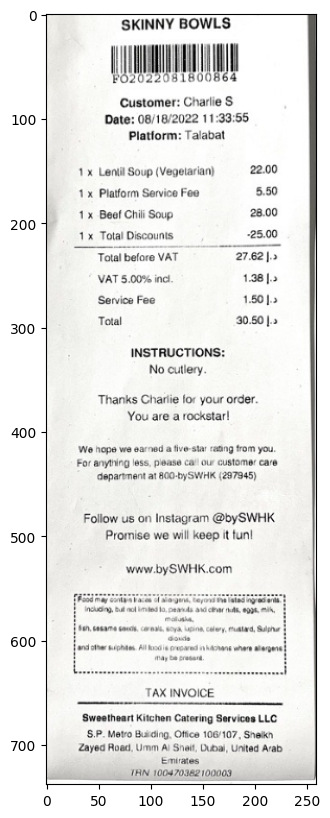

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

## doctr OCR match test

In [ ]:
import os
import cv2
from PIL import Image
from doctr.io import DocumentFile
from doctr.models import ocr_predictor

model = ocr_predictor(pretrained=True)

In [ ]:
# img_path = "receipt_1.png"
# pages = DocumentFile.from_images(img_path)

import pypdfium2 as pdfium
img_path = "receipt_1.png"
with pdfium.PdfDocument(img_path) as pdf:
    image = np.asarray([img for img in pdf.render_topil(scale=2)][0])
pages = [image]


# Analyze
ocr_output = model(pages)
ocr_output = [
    {"box": [*word.geometry[0], *word.geometry[1]],
    "text": word.value,
    "page_id": page_num,
    "block_id": block_num,
    "line_id": line_num,
    "word_id": word_num}
    for page_num, page in enumerate(ocr_output.pages)
    for block_num, block in enumerate(page.blocks)
    for line_num, line in enumerate(block.lines)
    for word_num, word in enumerate(line.words)
]

In [ ]:
image = np.asarray(image)
ih, iw = image.shape[:2]

for obj in ocr_output:
    x1,y1,x2,y2 = obj["box"]
    x1 *= iw
    x2 *= iw
    y1 *= ih
    y2 *= ih
    x1,y1,x2,y2 = map(int, [x1,y1,x2,y2])
    cv2.putText(image, obj["text"], (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0, 0, 255), thickness=1)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255,100,200), 2)

In [ ]:
Image.fromarray(image)

In [ ]:
from difflib import SequenceMatcher as SM


def get_closest_match_idx(target_word: str, candidate_words: List[str]):
    match_scores = np.asarray([SM(None, target_word.lower(), word.lower()).ratio() for word in candidate_words])
    max_idx = np.argmax(match_scores)
    return max_idx

In [ ]:
preds_with_fuzzy_matched = []
cand_words = [out["text"] for out in ocr_output]

for pred_obj in modified_output["predictions"]:
    temp_pred_obj = {}
    for top_key, top_val in pred_obj.items():
        if top_key in nested_list_set:
            temp_pred_obj[top_key] = []
            for item in top_val:
                temp_item_obj = {}
                for item_key, item_val in item.items():
                    text, conf, _, max_bbox = item_val
                    text = ' '.join([cand_words[get_closest_match_idx(_text, cand_words)]
                                    for _text in text.split()])
                    temp_item_obj[item_key] = [text, conf]
                temp_pred_obj[top_key].append(temp_item_obj)
        elif top_key in nested_dict_set:
            temp_item_obj = {}
            for sub_key, sub_val in top_val.items():
                text, conf, _, max_bbox = sub_val
                text = ' '.join([cand_words[get_closest_match_idx(_text, cand_words)]
                            for _text in text.split()])
                temp_item_obj[sub_key] = [text, conf]
            temp_pred_obj[top_key] = temp_item_obj
        elif top_key == "ReceiptType":
            text, conf, _, max_bbox = top_val
            temp_pred_obj[top_key] = [text, conf]
        else:
            text, conf, _, max_bbox = top_val
            text = ' '.join([cand_words[get_closest_match_idx(_text, cand_words)]
                            for _text in text.split()])
            temp_pred_obj[top_key] = [text, conf]
    preds_with_fuzzy_matched.append(temp_pred_obj)

In [ ]:
# remove everything except texts and confs 
modified_output["predictions"]
filtered_modified_output = []

for pred_obj in modified_output["predictions"]:
    temp_pred_obj = {}
    for top_key, top_val in pred_obj.items():
        if top_key in nested_list_set:
            temp_pred_obj[top_key] = []
            for item in top_val:
                temp_item_obj = {}
                for item_key, item_val in item.items():
                    text, conf = item_val[:2]
                    temp_item_obj[item_key] = [text, conf]
                temp_pred_obj[top_key].append(temp_item_obj)
        elif top_key in nested_dict_set:
            temp_item_obj = {}
            for sub_key, sub_val in top_val.items():
                text, conf = sub_val[:2]
                temp_item_obj[sub_key] = [text, conf]
            temp_pred_obj[top_key] = temp_item_obj
        else:
            text, conf = top_val[:2]
            temp_pred_obj[top_key] = [text, conf]
    filtered_modified_output.append(temp_pred_obj)

In [ ]:
filtered_modified_output

In [ ]:
preds_with_fuzzy_matched